## Analysis of historical data of IPC levels
For this analysis we use two sources of IPC levels, those produced by FewsNet (https://fews.net) and those producted by Global IPC (http://www.ipcinfo.org).   
FewsNet has produced these analyses since 2009. Global IPC is a more recent initiative where the timing and coverage of the analysis depends on the country. For Ethiopia currently (Oct 2020) two analyses have been done, one in 2019 and one in 2020. 

### No Global IPC data exists for Chad

### Have to add nov-2020, dec-2020,jan-2021

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.dates as dates
from sklearn.metrics import accuracy_score
import geopandas as gpd
import math
import matplotlib.ticker as plticker
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import sys
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from indicators.food_insecurity.config import Config

In [2]:
country="tcd"
admin_level=1
#suffix of filenames
suffix=""
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
adm1_bound_path= os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
fnwp_dir = os.path.join(country_folder, config.DATA_DIR, config.FEWSWORLDPOP_PROCESSED_DIR)
fnwp_path = os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=admin_level,suffix=suffix))

#### Load FewsNet data

In [3]:
df_fadm=pd.read_csv(fnwp_path)
df_fadm.date=pd.to_datetime(df_fadm.date)

In [4]:
#these are updates without new CS data, remove for cleanness
df_fadm=df_fadm[~df_fadm.date.isin(["2020-11-01","2020-12-01"])]

In [5]:
df_fadm["date"]=pd.to_datetime(df_fadm["date"])

In [6]:
df_fnat=pd.read_csv(os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=0,suffix=suffix)))

In [7]:
#these are updates without new CS data, remove for cleanness
df_fnat=df_fnat[~df_fnat.date.isin(["2020-12-01","2020-11-01"])]

In [8]:
df_fnat["date"]=pd.to_datetime(df_fnat["date"])

##### Check for missing data

In [10]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_fadm[df_fadm.pop_CS==0]))

Number of date-admin1 combinations with no IPC CS data: 26


In [11]:
print("Percentage of missing data:",len(df_fadm[df_fadm.pop_CS==0])/len(df_fadm)*100)

Percentage of missing data: 2.757158006362672


### Analysis of historical IPC values
To get a better understanding of the country's typical values and history, both on national and admin1 level

In [17]:
def plot_ipclevels(df,admc="ADMIN1",pop_col="pop_total_CS",status="CS",perc=False,figsize=(20,8),width=75,title=None,colp_num=2):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
#     width = 75
    count = 1
    fig, ax = plt.subplots(figsize=figsize)
    if perc:
        perc_str="perc_"
    else:
        perc_str=""
    if f"{perc_str}{status}_12" not in df.columns:
        df[f"{perc_str}{status}_12"]=df[f"{perc_str}{status}_1"]+df[f"{perc_str}{status}_2"]
    num_plots = len(df[admc].unique())
    if num_plots==1:
        colp_num=1
    rows = math.ceil(num_plots / colp_num)
    for region in df[admc].unique():
        
        ax = plt.subplot(rows,colp_num,count)
        df_c=df.copy()
        data = df_c.loc[df_c[admc]==region,:]
        
        p4 = plt.bar(data['date'], data[f'{perc_str}{status}_5'], width=width, color=color_map[5],label="IPC 5")
        p4 = plt.bar(data['date'], data[f'{perc_str}{status}_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data[f'{perc_str}{status}_3'], width=width, color=color_map[3], bottom=(data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data[f'{perc_str}{status}_2'], width=width, color=color_map[2], bottom=(data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 2")
        p2 = plt.bar(data['date'], data[f'{perc_str}{status}_1'], width=width, color=color_map[1], bottom=(data[f'{perc_str}{status}_2']+data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 1")
        if not perc:
            data["pop_miss"]=data[pop_col]-(data[f"pop_{status}"].replace(np.nan,0))
        else:
            data["perc_analyzed"]=data[[f"{perc_str}{status}_{i}" for i in range(1,6)]].sum(axis=1)
            data["pop_miss"]=round(100-data["perc_analyzed"])
        p1 = plt.bar(data['date'], data['pop_miss'], width=width, color=color_map[99], bottom=(data[f"{perc_str}{status}_1"]+data[f"{perc_str}{status}_2"]+data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).replace(np.nan,0).to_numpy(),label="Missing data")
        if title is not None:
            plt.title(title)
        else:
            plt.title(f"{region} {perc_str}{status}")
        

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        if not perc:
            ax.set_ylabel("Population")
            plt.plot(data['date'], data[f"pop_{status}"]/40 , color='red',label="2.5% of analyzed population",alpha=0.8)
            plt.plot(data['date'], data[f"pop_{status}"]/10 , color='blue',label="10% of analyzed population",alpha=0.8)
            plt.plot(data['date'], data[f"pop_{status}"]/5 , color='black',label="20% of analyzed population",alpha=0.8)
        else:
            ax.set_ylabel("Percentage of population")
#             ax.axhline(y=2.5,label="2.5 %",color="red",alpha=0.5)
#             ax.axhline(y=10,label="10 %",color="blue",alpha=0.5)
#             ax.axhline(y=20,label="20 %",color="black",alpha=0.5)
            loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
        ax.xaxis.set_minor_locator(dates.MonthLocator())
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(dates.YearLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y'))
        ax.xaxis.remove_overlapping_locs=False
        plt.tight_layout()
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        ax.set_xticks(data.date.values,minor=True)
        ax.xaxis.get_majorticklabels()[-1].set_visible(False)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
#         # Draw horizontal axis lines
#         vals = ax.get_yticks()
#         for tick in vals:
#             ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False)
        count+=1
    fig.tight_layout(pad=3.0)
    return fig

#### FewsNet

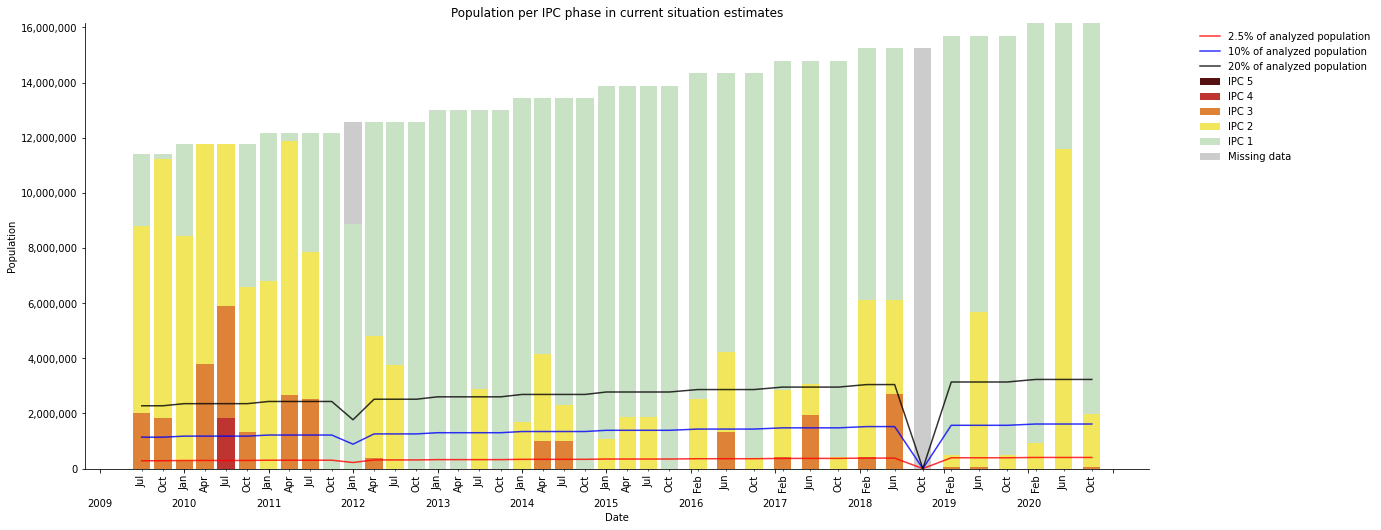

In [14]:
fig=plot_ipclevels(df_fnat,admc="ADMIN0",title="Population per IPC phase in current situation estimates",figsize=(20,8))
fig.savefig("../results/food_insecurity/historical_IPC_FN_CS_pop.png")

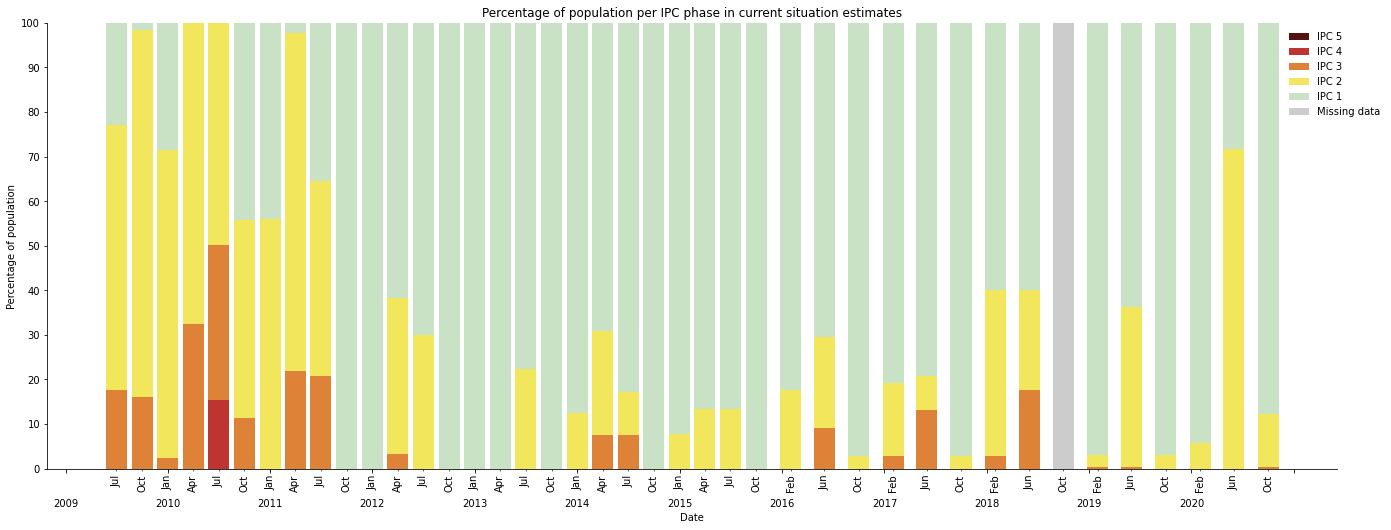

In [18]:
fig=plot_ipclevels(df_fnat,admc="ADMIN0",status="CS",perc=True,title="Percentage of population per IPC phase in current situation estimates")
fig.savefig("../results/food_insecurity/historical_IPC_FN_CS_perc.png")

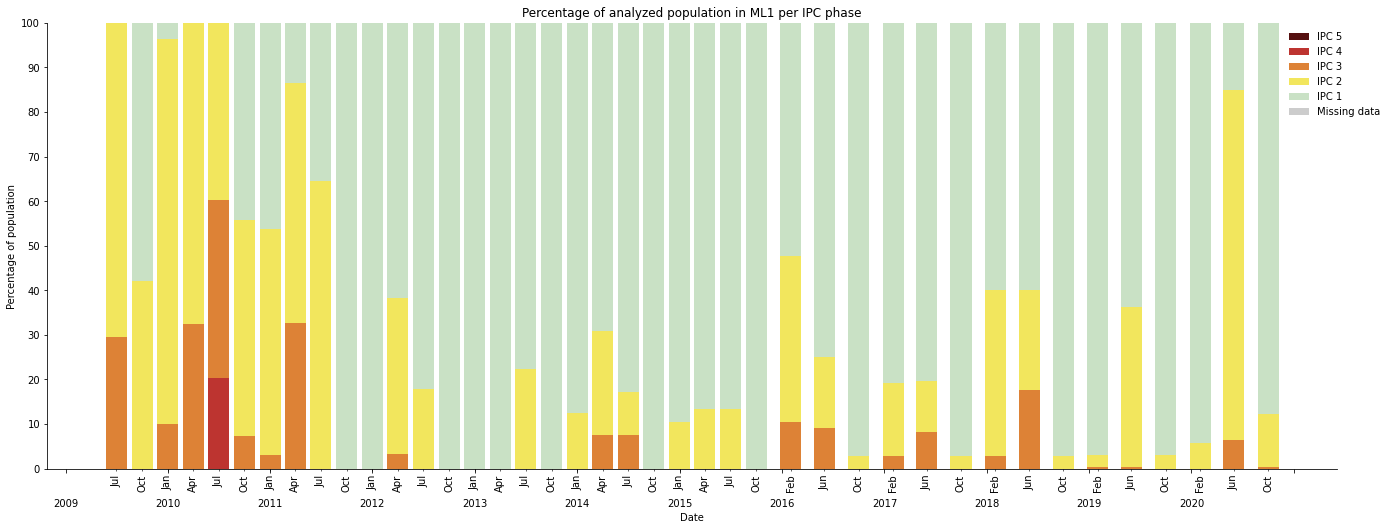

In [19]:
fig=plot_ipclevels(df_fnat,admc="ADMIN0",status="ML1",perc=True,title="Percentage of analyzed population in ML1 per IPC phase")

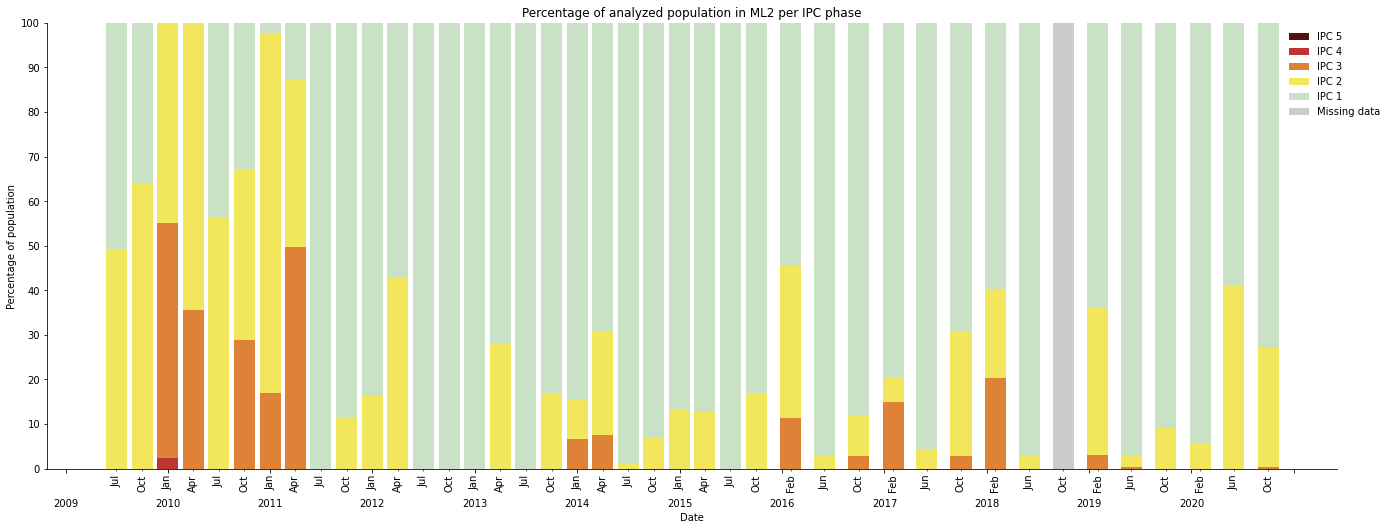

In [20]:
fig=plot_ipclevels(df_fnat,admc="ADMIN0",status="ML2",perc=True,title="Percentage of analyzed population in ML2 per IPC phase")

### TODO: there is something really strange with FN Jun-2018 data. There are duplicate shapes. Removed them in the processing, but now seems they are not equally divided over the admin1's

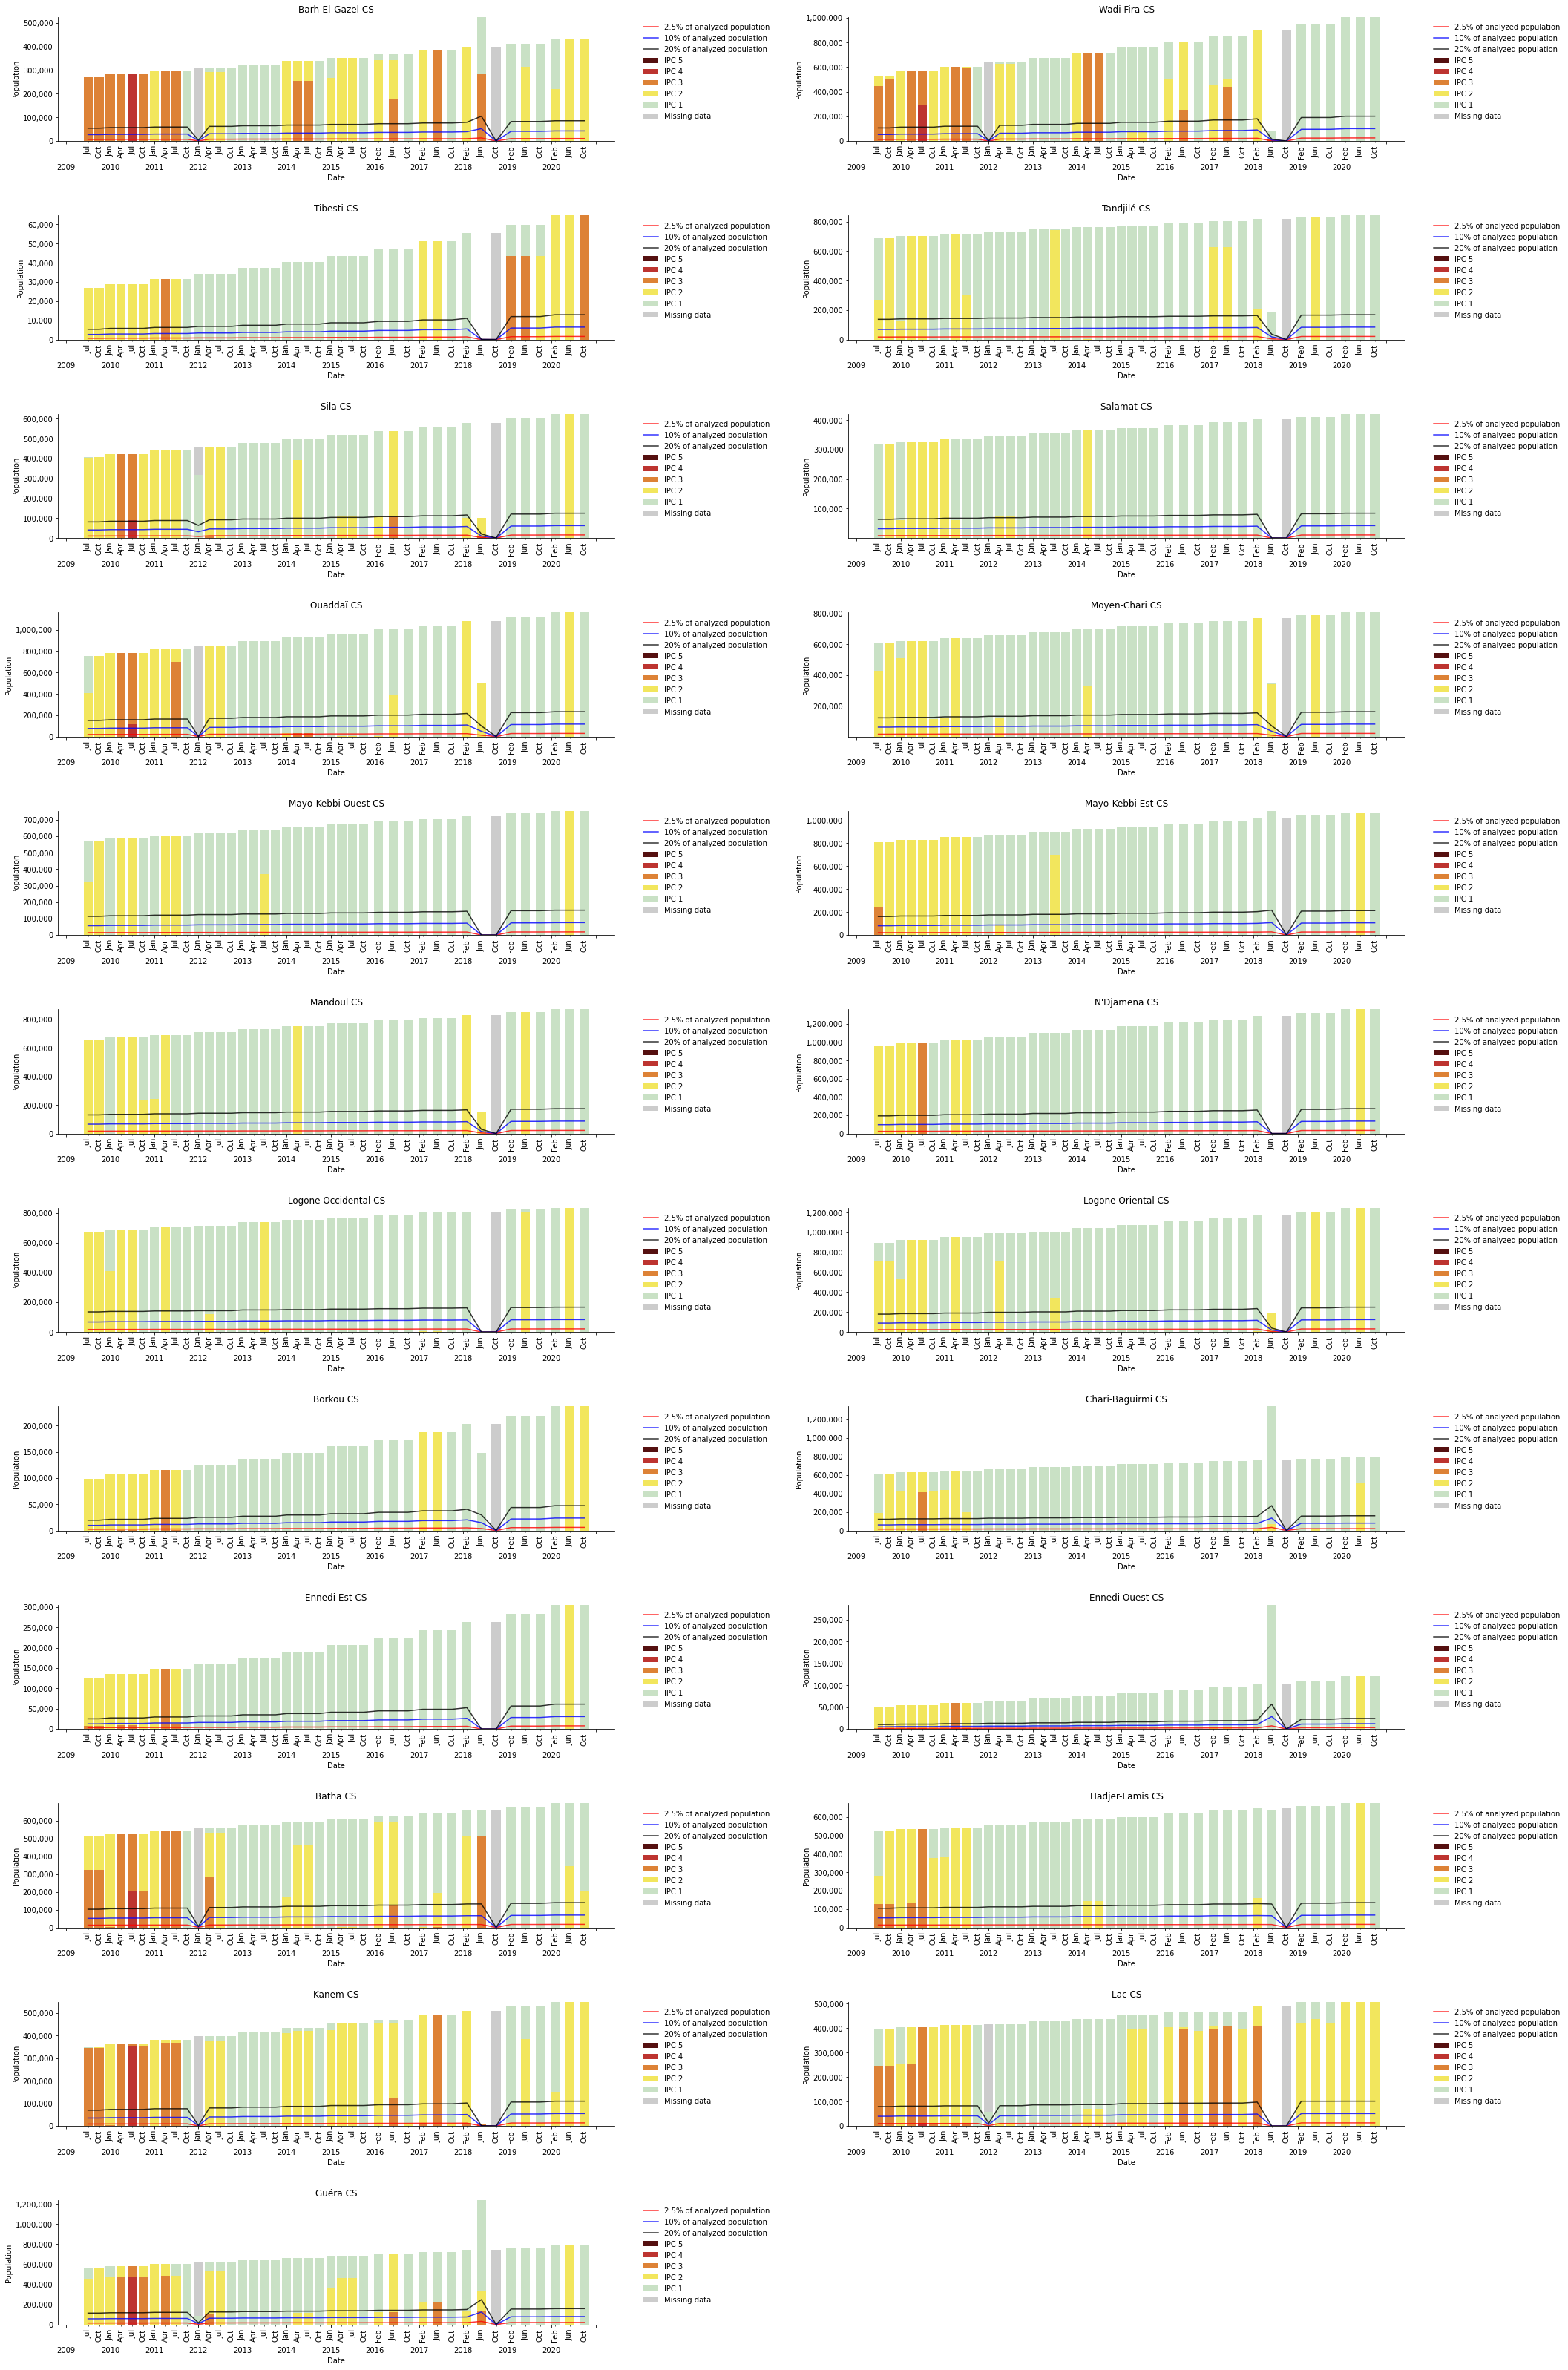

In [21]:
fig=plot_ipclevels(df_fadm,figsize=(30,45))